In [26]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from glob import glob
import os
from astropy.visualization import (ZScaleInterval, ImageNormalize, LogStretch, 
            ManualInterval, SqrtStretch, AsymmetricPercentileInterval)
import h5py 
from astropy.nddata import CCDData, StdDevUncertainty, NDDataArray
import astropy.constants as const
from astropy.wcs import FITSFixedWarning
import astropy.units as u
import warnings
warnings.simplefilter("ignore", category=FITSFixedWarning)
from specutils import Spectrum1D
from specutils.manipulation import SplineInterpolatedResampler
from datetime import datetime, timedelta
from ccdproc import ImageFileCollection
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import AutoLocator, AutoMinorLocator, FixedLocator, FixedFormatter, LogLocator, StrMethodFormatter
from matplotlib import patches
from matplotlib.markers import MarkerStyle
import cmcrameri.cm as cmcm
import cmasher as cmr
from scipy import ndimage
from scipy.io import readsav
import copy
from juanfit import SpectrumFitSingle, SpectrumFitRow, gaussian
from astropy.convolution import Gaussian2DKernel, interpolate_replace_nans
import eispac
from num2tex import num2tex
from scipy.interpolate import interp1d

In [2]:
green_path = "../../src/EclipseSpectra2017/MikesData_l1/Green/"
red_path = "../../src/EclipseSpectra2017/MikesData_l1/Red/"

totality_green_im_collection = ImageFileCollection(green_path,
                        glob_include="TotalitySequence*.fit")
totality_green_df = totality_green_im_collection.summary.to_pandas()
totality_green_df["date-obs"] = pd.to_datetime(totality_green_df["date-obs"])

totality_green_df_cut = totality_green_df.loc[(totality_green_df['date-obs'] >= datetime(2017,8,21,17,46,38)) & 
                                        (totality_green_df['date-obs'] < datetime(2017,8,21,17,47,0))]
totality_green_df_cut.sort_values(by="date-obs")
totality_green_df_cut = totality_green_df_cut.reset_index(drop=True)

totality_green_df_ext = totality_green_df.loc[(totality_green_df['date-obs'] >= datetime(2017,8,21,17,45,36)) & 
                                        (totality_green_df['date-obs'] < datetime(2017,8,21,17,47,8))]
totality_green_df_ext.sort_values(by="date-obs")                                        
totality_green_df_ext = totality_green_df_ext.reset_index(drop=True)

totality_red_im_collection = ImageFileCollection(red_path,
                        glob_include="TotalitySequence*.fit")
totality_red_df = totality_red_im_collection.summary.to_pandas()
totality_red_df["date-obs"] = pd.to_datetime(totality_red_df["date-obs"])

totality_red_df_cut = totality_red_df.loc[(totality_red_df['date-obs'] >= datetime(2017,8,21,17,46,40)) & 
                                        (totality_red_df['date-obs'] < datetime(2017,8,21,17,47,0))]
totality_red_df_cut.sort_values(by="date-obs")
totality_red_df_cut = totality_red_df_cut.reset_index(drop=True)

totality_red_df_ext = totality_red_df.loc[(totality_red_df['date-obs'] >= datetime(2017,8,21,17,45,36)) & 
                                        (totality_red_df['date-obs'] < datetime(2017,8,21,17,47,2))]
totality_red_df_ext.sort_values(by="date-obs")
totality_red_df_ext = totality_red_df_ext.reset_index(drop=True)

In [3]:
FeXI_line_cont_frame = CCDData.read("../../src/EclipseSpectra2017/MitchellData/MitchellFeXILine_ContRatio.fits",unit="adu")
FeXI_line_cont_image = FeXI_line_cont_frame.data
sun_center_FeXI = (np.float64(FeXI_line_cont_frame.header["SUNX"]),np.float64(FeXI_line_cont_frame.header["SUNY"]))
FeXI_line_cont_xslice = slice(372-300,372+301)
FeXI_line_cont_yslice = slice(383-220,383+221)
FeXI_line_cont_cutout = FeXI_line_cont_image[FeXI_line_cont_yslice, FeXI_line_cont_xslice]
FeXI_rotate_center = (sun_center_FeXI[0] - FeXI_line_cont_xslice.start, sun_center_FeXI[1] - FeXI_line_cont_yslice.start)
FeXI_line_cont_image_rot_scipy = ndimage.rotate(FeXI_line_cont_cutout, angle=360 - np.float64(FeXI_line_cont_frame.header["SUNROT"]),reshape=False,order=1)


FeXIV_line_cont_frame = CCDData.read("../../src/EclipseSpectra2017/MitchellData/MitchellFeXIVLine_ContRatio.fits",unit="adu")
FeXIV_line_cont_image = FeXIV_line_cont_frame.data
sun_center_FeXIV = (np.float64(FeXIV_line_cont_frame.header["SUNX"]),np.float64(FeXIV_line_cont_frame.header["SUNY"]))
FeXIV_line_cont_xslice = slice(372-300,372+301)
FeXIV_line_cont_yslice = slice(383-220,383+221)
FeXIV_line_cont_cutout = FeXIV_line_cont_image[FeXIV_line_cont_yslice, FeXIV_line_cont_xslice]
FeXIV_rotate_center = (sun_center_FeXIV[0] - FeXIV_line_cont_xslice.start, sun_center_FeXIV[1] - FeXIV_line_cont_yslice.start)
FeXIV_line_cont_image_rot_scipy = ndimage.rotate(FeXIV_line_cont_cutout, angle=360 - np.float64(FeXIV_line_cont_frame.header["SUNROT"]),reshape=False,order=1)

In [4]:
with h5py.File("../../sav/Eclipse/LimbTrack/sun_pos_linear_fit.h5", 'r') as hf:
    sun_x_fitparam = hf['sun_x_fitparam'][:]
    sun_y_fitparam = hf['sun_y_fitparam'][:]

sun_x_fitpoly = np.poly1d(sun_x_fitparam)
sun_y_fitpoly = np.poly1d(sun_y_fitparam)

In [5]:
slit_pos = 209.4
rsun_arcsec = 950.0
rsun_context_pixel = 71.4
pixel_ratio = rsun_context_pixel/np.float64(FeXI_line_cont_frame.header["MOONR"])
img_pixel_to_arcsec = np.float64(FeXI_line_cont_frame.header["SUNR"])/rsun_arcsec
pixel_ratio_to_arcsec = rsun_context_pixel/np.float64(FeXI_line_cont_frame.header["MOONR"])*img_pixel_to_arcsec
rotate_angle_context = -27.5

eis_idl_sav = readsav("../../sav/EIS/EQSPY/EQSPY_lvl1_offset_170821_tilt_cor.sav",verbose=False)
eis_eqs_xcen, eis_eqs_ycen = np.array((eis_idl_sav["xcen"], eis_idl_sav["ycen_195"])) + eis_idl_sav["xy_correct_aia"]
eis_eqs_fovx, eis_eqs_fovy = np.array((eis_idl_sav["fovx"], eis_idl_sav["fovy"]))
eis_eqs_xstart = eis_eqs_xcen - eis_eqs_fovx/2.
eis_eqs_xend = eis_eqs_xcen + eis_eqs_fovx/2.
eis_eqs_ystart = eis_eqs_ycen - eis_eqs_fovy/2.
eis_eqs_yend = eis_eqs_ycen + eis_eqs_fovy/2.

In [6]:
eis_db_fe_10_184_fit_file = "../../sav/EIS/NPCHDB/eispac_fit/eis_20170821_110818.fe_10_184_536.1c-0.fit.h5"
eis_db_fe_10_184_fit_res = eispac.read_fit(eis_db_fe_10_184_fit_file)

Reading fit result from, 
   ../../sav/EIS/NPCHDB/eispac_fit/eis_20170821_110818.fe_10_184_536.1c-0.fit.h5


In [7]:
green_frame_wavelength = CCDData.read(os.path.join(green_path,totality_green_df_cut.iloc[0]["file"]),hdu=1,unit="adu").data

with h5py.File("../../sav/Eclipse/FitResults/FeXIV_add3orders.h5", 'r') as hf:
    green_fit_matrix_ext = hf['green_fit_matrix_ext'][:]
    green_fit_matrix_ext_err = hf['green_fit_matrix_ext_err'][:]
    green_fit_matrix_bin_ext = hf['green_fit_matrix_bin_ext'][:]
    green_fit_matrix_bin_ext_err = hf['green_fit_matrix_bin_ext_err'][:]
    green_fit_filename_index = hf['green_fit_filename_index'][:]
    green_fit_filename_index = hf['green_fit_filename_index'][:]

In [8]:
with h5py.File("../../sav/Eclipse/FitResults/FeXIV_63.h5", 'r') as hf:
    green_fit_matrix_ext_63 = hf['green_fit_matrix_ext'][:]
    green_fit_matrix_ext_err_63 = hf['green_fit_matrix_ext_err'][:]
    green_fit_matrix_bin_ext_63 = hf['green_fit_matrix_bin_ext'][:]
    green_fit_matrix_bin_ext_err_63 = hf['green_fit_matrix_bin_ext_err'][:]

with h5py.File("../../sav/Eclipse/FitResults/FeXIV_62.h5", 'r') as hf:
    green_fit_matrix_ext_62 = hf['green_fit_matrix_ext'][:]
    green_fit_matrix_ext_err_62 = hf['green_fit_matrix_ext_err'][:]
    green_fit_matrix_bin_ext_62 = hf['green_fit_matrix_bin_ext'][:]
    green_fit_matrix_bin_ext_err_62 = hf['green_fit_matrix_bin_ext_err'][:]

with h5py.File("../../sav/Eclipse/FitResults/FeXIV_61.h5", 'r') as hf:
    green_fit_matrix_ext_61 = hf['green_fit_matrix_ext'][:]
    green_fit_matrix_ext_err_61 = hf['green_fit_matrix_ext_err'][:]
    green_fit_matrix_bin_ext_61 = hf['green_fit_matrix_bin_ext'][:]
    green_fit_matrix_bin_ext_err_61 = hf['green_fit_matrix_bin_ext_err'][:]

In [9]:
green_limb_loc = np.array([396.,625.,])
x_1d_grid_green_ext = np.arange(-63,125,1,dtype=np.float64)
y_1d_grid_green_ext = np.arange(np.mean(green_limb_loc) - 699.,  np.mean(green_limb_loc) - 349., 1, dtype=np.float64)

y_1d_grid_green_arcsec_ext = y_1d_grid_green_ext/(np.diff(green_limb_loc)/2.)*rsun_arcsec * \
        np.float64(FeXI_line_cont_frame.header["MOONR"])/np.float64(FeXI_line_cont_frame.header["SUNR"])
x_1d_grid_green_arcsec_ext = x_1d_grid_green_ext * (sun_x_fitpoly(10) - sun_x_fitpoly(9.5))/pixel_ratio_to_arcsec
y_1d_grid_green_arcsec_bin_ext = np.average(y_1d_grid_green_arcsec_ext.reshape(-1,5),axis=1)

x_2d_grid_green_arcsec_ext, y_2d_grid_green_arcsec_ext = np.meshgrid(x_1d_grid_green_arcsec_ext, y_1d_grid_green_arcsec_ext)
x_2d_grid_green_arcsec_bin_ext, y_2d_grid_green_arcsec_bin_ext = np.meshgrid(x_1d_grid_green_arcsec_ext, y_1d_grid_green_arcsec_bin_ext)

y_green_step_correction_ext = (sun_y_fitpoly(np.linspace(0,93.5,188)) - sun_y_fitpoly(62))/rsun_context_pixel*rsun_arcsec * \
        np.float64(FeXI_line_cont_frame.header["MOONR"])/np.float64(FeXI_line_cont_frame.header["SUNR"])
y_green_step_correction_ext = np.flip(y_green_step_correction_ext)

y_2d_grid_green_arcsec_correct_ext = y_2d_grid_green_arcsec_ext + y_green_step_correction_ext[np.newaxis,:]
y_2d_grid_green_arcsec_bin_correct_ext = y_2d_grid_green_arcsec_bin_ext + y_green_step_correction_ext[np.newaxis,:]

x_2d_grid_green_arcsec_rot_ext = np.cos(np.deg2rad(np.abs(rotate_angle_context)))*x_2d_grid_green_arcsec_ext + \
                            np.sin(np.deg2rad(np.abs(rotate_angle_context)))*y_2d_grid_green_arcsec_correct_ext

y_2d_grid_green_arcsec_rot_ext = - np.sin(np.deg2rad(np.abs(rotate_angle_context)))*x_2d_grid_green_arcsec_ext + \
                            np.cos(np.deg2rad(np.abs(rotate_angle_context)))*y_2d_grid_green_arcsec_correct_ext

x_2d_grid_green_arcsec_bin_rot_ext = np.cos(np.deg2rad(np.abs(rotate_angle_context)))*x_2d_grid_green_arcsec_bin_ext + \
                            np.sin(np.deg2rad(np.abs(rotate_angle_context)))*y_2d_grid_green_arcsec_bin_correct_ext

y_2d_grid_green_arcsec_bin_rot_ext = - np.sin(np.deg2rad(np.abs(rotate_angle_context)))*x_2d_grid_green_arcsec_bin_ext + \
                            np.cos(np.deg2rad(np.abs(rotate_angle_context)))*y_2d_grid_green_arcsec_bin_correct_ext

In [10]:
img_center = np.array([300,220])

def func_img_xpixel_to_xarcsec(x):
    return (x - img_center[0])/img_pixel_to_arcsec

def func_img_xarcsec_to_xpixel(x):
    return x*img_pixel_to_arcsec + img_center[0]

def func_img_ypixel_to_yarcsec(x):
    return (x - img_center[1])/img_pixel_to_arcsec

def func_img_yarcsec_to_ypixel(x):
    return x*img_pixel_to_arcsec + img_center[1]

def plot_colorbar(im, ax, width="3%", height="100%",loc="lower left",fontsize=14,
                  bbox_to_anchor=(1.02, 0., 1, 1)):
    clb_ax = inset_axes(ax,width=width,height=height,loc=loc,
                bbox_to_anchor=bbox_to_anchor,
                 bbox_transform=ax.transAxes,
                 borderpad=0)
    clb = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=ax,cax=clb_ax)
    clb_ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    clb_ax.yaxis.get_offset_text().set_fontsize(fontsize)
    clb_ax.tick_params(labelsize=fontsize)
    return clb, clb_ax

In [11]:
FeXIV_xslice = slice(345,395)
pixel_size_green = np.abs(np.mean(np.diff((green_frame_wavelength/63./10.)[FeXIV_xslice])))
inst_width_pix_green = 1.86
inst_width_nm_green = pixel_size_green*inst_width_pix_green

print(pixel_size_green, inst_width_nm_green)

0.02413460883717655 0.044890372437148385


In [12]:
img_xpixel_array = np.arange(FeXIV_line_cont_image_rot_scipy.shape[1])
img_ypixel_array = np.arange(FeXIV_line_cont_image_rot_scipy.shape[0])

img_xarcsec_array = func_img_xpixel_to_xarcsec(img_xpixel_array)
img_yarcsec_array = func_img_ypixel_to_yarcsec(img_ypixel_array)

slit_xshift_green = sun_x_fitpoly(62) - slit_pos
slit_center_x_green =  - slit_xshift_green/pixel_ratio_to_arcsec*np.cos(np.deg2rad(np.abs(rotate_angle_context)))
slit_center_y_green =  slit_xshift_green/pixel_ratio_to_arcsec*np.sin(np.deg2rad(np.abs(rotate_angle_context)))

In [13]:
mask_bad_fit_matrix_ext = np.where(np.any(np.abs(green_fit_matrix_ext_err/green_fit_matrix_ext)[:3,:,:] > 0.5,axis=0) | \
                np.any(np.isnan(green_fit_matrix_ext_err),axis=0))
mask_bad_fit_matrix_bin_ext = np.where(np.any(np.abs(green_fit_matrix_bin_ext_err/green_fit_matrix_bin_ext)[:3,:,:] > 0.2,axis=0) | \
                np.any(np.isnan(green_fit_matrix_bin_ext_err),axis=0))

kernel = Gaussian2DKernel(x_stddev=1,y_stddev=2)
kernel_bin = Gaussian2DKernel(x_stddev=1,y_stddev=0.2)

green_where_disk_ext = np.where((x_2d_grid_green_arcsec_rot_ext + slit_center_x_green)**2 + \
                                    (y_2d_grid_green_arcsec_rot_ext + slit_center_y_green)**2 < 940**2)

green_line_int_masked = np.copy(green_fit_matrix_ext[1,:,:])
# green_line_int_masked[mask_bad_fit_matrix_ext] = np.nan
# green_line_int_masked = interpolate_replace_nans(green_line_int_masked,kernel)
green_line_int_masked[green_where_disk_ext] = np.nan

green_cont_masked = np.copy(green_fit_matrix_ext[3,:,:] + green_fit_matrix_ext[4,:,:])
# green_cont_masked[mask_bad_fit_matrix_ext] = np.nan
# green_cont_masked = interpolate_replace_nans(green_cont_masked, kernel)
green_cont_masked[green_where_disk_ext] = np.nan

green_line_cont_ratio_masked = green_fit_matrix_ext[1,:,:]/(green_fit_matrix_ext[3,:,:] + green_fit_matrix_ext[4,:,:])
# green_line_cont_ratio_masked[mask_bad_fit_matrix_ext] = np.nan
# green_line_cont_ratio_masked = interpolate_replace_nans(green_line_cont_ratio_masked,kernel)
green_line_cont_ratio_masked[green_where_disk_ext] = np.nan

green_where_disk_bin_ext = np.where((x_2d_grid_green_arcsec_bin_rot_ext + slit_center_x_green)**2 + \
                                    (y_2d_grid_green_arcsec_bin_rot_ext + slit_center_y_green)**2 < 940**2)

green_vlos_masked = -(np.copy(green_fit_matrix_bin_ext[0,:,:]) - 530.29)/530.29*const.c.cgs.value*1e-5
green_vlos_masked[np.where(green_fit_matrix_bin_ext[1,:,:] < 15)] = np.nan
green_vlos_masked[mask_bad_fit_matrix_bin_ext] = np.nan
green_vlos_masked[green_where_disk_bin_ext] = np.nan
green_vlos_masked = green_vlos_masked - np.nanmedian(green_vlos_masked)
# green_vlos_masked = interpolate_replace_nans(green_vlos_masked,kernel_bin)
green_vlos_masked[green_where_disk_bin_ext] = np.nan


green_fwhm_masked = np.copy(green_fit_matrix_bin_ext[2,:,:])
green_fwhm_masked[np.where(green_fit_matrix_bin_ext[1,:,:] < 15)] = np.nan
green_fwhm_masked[mask_bad_fit_matrix_bin_ext] = np.nan
# green_fwhm_masked_err[green_where_disk_bin_ext] = np.nan        
green_veff_masked = np.sqrt(green_fwhm_masked**2 - inst_width_nm_green**2)/530.29*const.c.cgs.value*1e-5/np.sqrt(4*np.log(2))
# green_veff_masked = interpolate_replace_nans(green_veff_masked,kernel_bin)
green_veff_masked[green_where_disk_bin_ext] = np.nan

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


In [14]:
def find_nearest_pixel(x,y,x_grid,y_grid):
    distance = np.sqrt((x - x_grid)**2 + (y - y_grid)**2)
    index = np.unravel_index(np.argmin(distance),distance.shape)
    return index

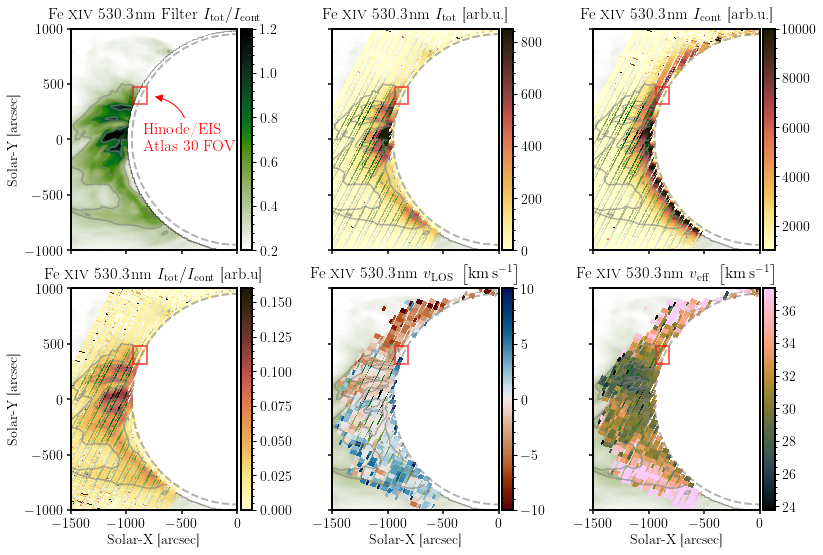

In [15]:
img_center = np.array([300,220])
img_xpixel_array = np.arange(FeXIV_line_cont_image_rot_scipy.shape[1])
img_ypixel_array = np.arange(FeXIV_line_cont_image_rot_scipy.shape[0])

img_xarcsec_array = func_img_xpixel_to_xarcsec(img_xpixel_array)
img_yarcsec_array = func_img_ypixel_to_yarcsec(img_ypixel_array)

colorbar_width = "7%"

def create_rec_eqs():
    return patches.Rectangle((eis_eqs_xstart, eis_eqs_ystart),
                            eis_eqs_fovx, eis_eqs_fovy,linewidth=2,edgecolor="red",
                            facecolor="none",alpha=0.6)

def create_limb_circle(rsun):
    return patches.Circle((0,0),rsun,linewidth=2,edgecolor="grey",
                            facecolor="none",alpha=0.6,ls="--")

slit_xshift_green = sun_x_fitpoly(62) - slit_pos
slit_center_x_green =  - slit_xshift_green/pixel_ratio_to_arcsec*np.cos(np.deg2rad(np.abs(rotate_angle_context)))
slit_center_y_green =  slit_xshift_green/pixel_ratio_to_arcsec*np.sin(np.deg2rad(np.abs(rotate_angle_context)))

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(11.2,7.6),constrained_layout=True)
im1 = ax1.pcolormesh(img_xarcsec_array,img_yarcsec_array,FeXIV_line_cont_image_rot_scipy,vmin=0.2,vmax=1.2,
                    cmap=cmr.jungle_r,shading="gouraud",rasterized=True)

plot_colorbar(im1, ax1,width=colorbar_width)
ax1.annotate(r"Hinode/EIS" +"\n" + r"Atlas 30 FOV",(-760,390),(-850,-100),arrowprops={"arrowstyle":"-|>",
            "connectionstyle":"arc3,rad=0.4","color":"red"},fontsize=16,color="red")

for ax_ in (ax2,ax3,ax4,ax5,ax6):
    ax_.pcolormesh(img_xarcsec_array,img_yarcsec_array,FeXIV_line_cont_image_rot_scipy,vmin=0.2,vmax=1.2,
                    cmap=cmr.jungle_r,shading="gouraud",rasterized=True,alpha=0.5)

im2 = ax2.pcolormesh(x_2d_grid_green_arcsec_rot_ext + slit_center_x_green,
                y_2d_grid_green_arcsec_rot_ext + slit_center_y_green,
                green_line_int_masked,cmap=cmcm.lajolla,rasterized=True,vmin=0,vmax=850,shading="auto")


plot_colorbar(im2, ax2,width=colorbar_width)

im3 = ax3.pcolormesh(x_2d_grid_green_arcsec_rot_ext + slit_center_x_green,
                y_2d_grid_green_arcsec_rot_ext + slit_center_y_green,
                green_cont_masked,cmap=cmcm.lajolla,rasterized=True,vmin=1000,vmax=10000)

plot_colorbar(im3, ax3,width=colorbar_width)

im4 = ax4.pcolormesh(x_2d_grid_green_arcsec_rot_ext + slit_center_x_green,
                y_2d_grid_green_arcsec_rot_ext + slit_center_y_green,
                green_line_cont_ratio_masked,cmap=cmcm.lajolla,rasterized=True,vmin=0,vmax=0.16)

plot_colorbar(im4, ax4,width=colorbar_width)

im5 = ax5.pcolormesh(x_2d_grid_green_arcsec_bin_rot_ext + slit_center_x_green,
                y_2d_grid_green_arcsec_bin_rot_ext + slit_center_y_green,
                green_vlos_masked,cmap=cmcm.vik_r,rasterized=True,vmin=-10,vmax=10)

plot_colorbar(im5, ax5,width=colorbar_width)

im6 = ax6.pcolormesh(x_2d_grid_green_arcsec_bin_rot_ext + slit_center_x_green,
                y_2d_grid_green_arcsec_bin_rot_ext + slit_center_y_green,
                green_veff_masked,cmap=cmcm.batlowK,rasterized=True,
                vmin=0.07/530.29*const.c.cgs.value*1e-5/np.sqrt(4*np.log(2))
                ,vmax=0.11/530.29*const.c.cgs.value*1e-5/np.sqrt(4*np.log(2)))

plot_colorbar(im6, ax6,width=colorbar_width)

ax1.set_ylabel("Solar-Y [arcsec]",fontsize=14)
ax4.set_xlabel("Solar-X [arcsec]",fontsize=14)
ax4.set_ylabel("Solar-Y [arcsec]",fontsize=14)
ax5.set_xlabel("Solar-X [arcsec]",fontsize=14)
ax6.set_xlabel("Solar-X [arcsec]",fontsize=14)

ax1.set_title(r"Fe \textsc{xiv} 530.3\,nm Filter $I_{\rm tot}/I_{\rm cont}$",fontsize=16,pad=10)
ax2.set_title(r"Fe \textsc{xiv} 530.3\,nm $I_{\rm tot}$ [arb.u.]",fontsize=16,pad=10)
ax3.set_title(r"Fe \textsc{xiv} 530.3\,nm $I_{\rm cont}$ [arb.u.]",fontsize=16,pad=10)
ax4.set_title(r"Fe \textsc{xiv} 530.3\,nm $I_{\rm tot}/I_{\rm cont}$ [arb.u]",fontsize=16,pad=10)
ax5.set_title(r"Fe \textsc{xiv} 530.3\,nm $v_{\rm LOS}\ \left[\mathrm{km\,s^{-1}}\right]$",fontsize=16,pad=10)
ax6.set_title(r"Fe \textsc{xiv} 530.3\,nm $v_{\rm eff}\ \left[\mathrm{km\,s^{-1}}\right]$",fontsize=16,pad=10)

xlim_zoomin = [-1500,0]
ylim_zoomin = [-1000,1000]


for ax_ in (ax2,ax3,ax5,ax6):
    ax_.tick_params(labelleft=False)

for ax_ in (ax1,ax2,ax3):
    ax_.tick_params(labelbottom=False)

for ax_ in (ax1,ax2,ax3,ax4,ax5,ax6):
    ax_.contour(img_xarcsec_array,img_yarcsec_array,FeXIV_line_cont_image_rot_scipy,levels=[0.4,0.65,0.9],alpha=0.6,
            colors=['grey'])
    ax_.add_patch(create_rec_eqs())
    ax_.add_patch(create_limb_circle(rsun_arcsec))
    ax_.set_aspect(1)
    ax_.tick_params(labelsize=14,which="both",width=1.5)
    ax_.set_xlim(xlim_zoomin)
    ax_.set_ylim(ylim_zoomin)
# plt.savefig(fname="../../figs/png/FeXIV_combine_3orders.png",format="png",dpi=300)

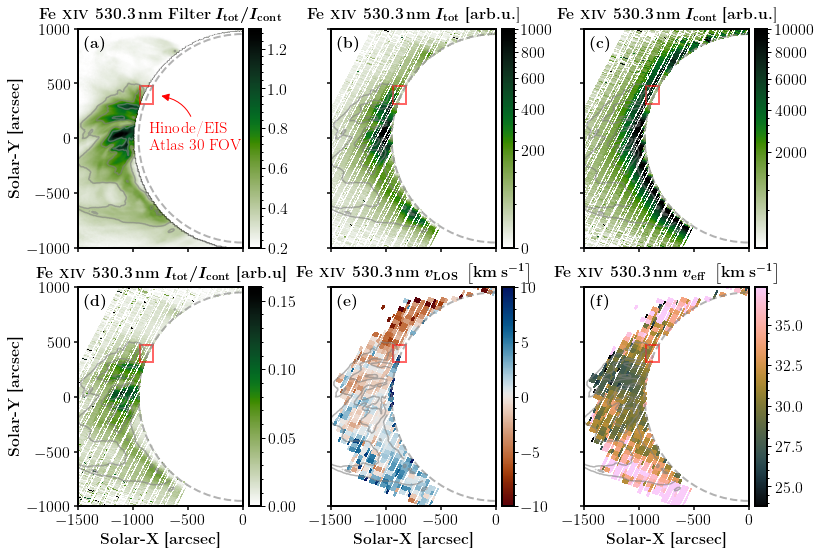

In [16]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(11,7.6),constrained_layout=True)
im1 = ax1.pcolormesh(img_xarcsec_array,img_yarcsec_array,FeXIV_line_cont_image_rot_scipy,vmin=0.2,vmax=1.3,
                    cmap=cmr.jungle_r,shading="gouraud",rasterized=True)

plot_colorbar(im1, ax1,width=colorbar_width,bbox_to_anchor=(1.04, 0., 1, 1),fontsize=16)
ax1.annotate(r"Hinode/EIS" +"\n" + r"Atlas 30 FOV",(-760,390),(-850,-100),arrowprops={"arrowstyle":"-|>",
            "connectionstyle":"arc3,rad=0.4","color":"red"},fontsize=16,color="red")

# for ax_ in (ax2,ax3,ax4,ax5,ax6):
#     ax_.pcolormesh(img_xarcsec_array,img_yarcsec_array,FeXIV_line_cont_image_rot_scipy,vmin=0.2,vmax=1.2,
#                     cmap=cmr.jungle_r,shading="gouraud",rasterized=True,alpha=0.5)

norm_green_line_int = ImageNormalize(data=green_line_int_masked,interval=ManualInterval(0,1000),stretch=SqrtStretch())

im2 = ax2.pcolormesh(x_2d_grid_green_arcsec_rot_ext + slit_center_x_green,
                y_2d_grid_green_arcsec_rot_ext + slit_center_y_green,
                green_line_int_masked,cmap=cmr.jungle_r,rasterized=True,shading="auto",
                norm=norm_green_line_int)


plot_colorbar(im2, ax2,width=colorbar_width,bbox_to_anchor=(1.04, 0., 1, 1),fontsize=16)

norm_green_cont_int = ImageNormalize(data=green_cont_masked,interval=ManualInterval(1e2,1e4),stretch=SqrtStretch())

im3 = ax3.pcolormesh(x_2d_grid_green_arcsec_rot_ext + slit_center_x_green,
                y_2d_grid_green_arcsec_rot_ext + slit_center_y_green,
                green_cont_masked,cmap=cmr.jungle_r,rasterized=True,norm=norm_green_cont_int)

plot_colorbar(im3, ax3,width=colorbar_width,bbox_to_anchor=(1.04, 0., 1, 1),fontsize=16)

im4 = ax4.pcolormesh(x_2d_grid_green_arcsec_rot_ext + slit_center_x_green,
                y_2d_grid_green_arcsec_rot_ext + slit_center_y_green,
                green_line_cont_ratio_masked,cmap=cmr.jungle_r,rasterized=True,vmin=0,vmax=0.16)

plot_colorbar(im4, ax4,width=colorbar_width,bbox_to_anchor=(1.04, 0., 1, 1),fontsize=16)

im5 = ax5.pcolormesh(x_2d_grid_green_arcsec_bin_rot_ext + slit_center_x_green,
                y_2d_grid_green_arcsec_bin_rot_ext + slit_center_y_green,
                green_vlos_masked,cmap=cmcm.vik_r,rasterized=True,vmin=-10,vmax=10)

plot_colorbar(im5, ax5,width=colorbar_width,bbox_to_anchor=(1.04, 0., 1, 1),fontsize=16)

im6 = ax6.pcolormesh(x_2d_grid_green_arcsec_bin_rot_ext + slit_center_x_green,
                y_2d_grid_green_arcsec_bin_rot_ext + slit_center_y_green,
                green_veff_masked,cmap=cmcm.batlowK,rasterized=True,
                vmin=0.07/530.29*const.c.cgs.value*1e-5/np.sqrt(4*np.log(2))
                ,vmax=0.11/530.29*const.c.cgs.value*1e-5/np.sqrt(4*np.log(2)))

plot_colorbar(im6, ax6,width=colorbar_width,bbox_to_anchor=(1.04, 0., 1, 1),fontsize=16)

ax1.set_ylabel(r"\textbf{Solar-Y [arcsec]}",fontsize=16)
ax4.set_xlabel(r"\textbf{Solar-X [arcsec]}",fontsize=16)
ax4.set_ylabel(r"\textbf{Solar-Y [arcsec]}",fontsize=16)
ax5.set_xlabel(r"\textbf{Solar-X [arcsec]}",fontsize=16)
ax6.set_xlabel(r"\textbf{Solar-X [arcsec]}",fontsize=16)

ax1.set_title(r"\textbf{Fe \textsc{xiv} 530.3\,nm Filter} $\boldsymbol{I_{\rm tot}/I_{\rm cont}}$",fontsize=16,pad=10)
ax2.set_title(r"\textbf{Fe \textsc{xiv} 530.3\,nm} $\boldsymbol{I_{\rm tot}}$ \textbf{[arb.u.}]",fontsize=16,pad=10)
ax3.set_title(r"\textbf{Fe \textsc{xiv} 530.3\,nm} $\boldsymbol{I_{\rm cont}}$ \textbf{[arb.u.}]",fontsize=16,pad=10)
ax4.set_title(r"\textbf{Fe \textsc{xiv} 530.3\,nm} $\boldsymbol{I_{\rm tot}/I_{\rm cont}}$ \textbf{[arb.u]}",fontsize=16,pad=10)
ax5.set_title(r"\textbf{Fe \textsc{xiv} 530.3\,nm} $\boldsymbol{v_{\rm LOS}\ \left[\mathrm{km\,s^{-1}}\right]}$",fontsize=16,pad=10)
ax6.set_title(r"\textbf{Fe \textsc{xiv} 530.3\,nm} $\boldsymbol{v_{\rm eff}\ \left[\mathrm{km\,s^{-1}}\right]}$",fontsize=16,pad=10)

for ax_, text_ in zip((ax1,ax2,ax3,ax4,ax5,ax6),
                      ("a","b","c","d","e","f")):
    ax_.text(0.035,0.97,r"\textbf{("+text_+r")}",fontsize=16,
             va="top",ha="left",transform=ax_.transAxes)

xlim_zoomin = [-1500,0]
ylim_zoomin = [-1000,1000]



for ax_ in (ax2,ax3,ax5,ax6):
    ax_.tick_params(labelleft=False)

for ax_ in (ax1,ax2,ax3):
    ax_.tick_params(labelbottom=False)

for ax_ in (ax1,ax2,ax3,ax4,ax5,ax6):
    ax_.contour(img_xarcsec_array,img_yarcsec_array,FeXIV_line_cont_image_rot_scipy,levels=[0.4,0.65,0.9],alpha=0.6,
            colors=['grey'])
    ax_.add_patch(create_rec_eqs())
    ax_.add_patch(create_limb_circle(rsun_arcsec))
    ax_.set_aspect(1)
    ax_.tick_params(labelsize=16,which="both",width=1.5)
    ax_.set_xlim(xlim_zoomin)
    ax_.set_ylim(ylim_zoomin)
# plt.savefig(fname="../../figs/png/FeXIV_combine_3orders.png",format="png",dpi=300)

In [17]:
with h5py.File("../../sav/Eclipse/FlatField/skyflat_green_1d_FeXIV_63rd.h5", 'r') as hf:
    flatfield_1d_FeXIV_63rd = hf['flatfield_1d'][:]

with h5py.File("../../sav/Eclipse/FlatField/skyflat_green_1d_FeXIV_62nd.h5", 'r') as hf:
    flatfield_1d_FeXIV_62nd = hf['flatfield_1d'][:]

with h5py.File("../../sav/Eclipse/FlatField/skyflat_green_1d_FeXIV_61st.h5", 'r') as hf:
    flatfield_1d_FeXIV_61st = hf['flatfield_1d'][:]

In [18]:
fit_matrices = [green_fit_matrix_ext_61, green_fit_matrix_ext_62, 
                green_fit_matrix_ext_63, green_fit_matrix_ext]

fit_matrices_err = [green_fit_matrix_ext_err_61, green_fit_matrix_ext_err_62, 
                green_fit_matrix_ext_err_63, green_fit_matrix_ext_err]

fit_bin_matrices = [green_fit_matrix_bin_ext_61, green_fit_matrix_bin_ext_62,
                    green_fit_matrix_bin_ext_63, green_fit_matrix_bin_ext]

fit_bin_matrices_err = [green_fit_matrix_bin_ext_err_61, green_fit_matrix_bin_ext_err_62,
                        green_fit_matrix_bin_ext_err_63, green_fit_matrix_bin_ext_err]

flatfields = [flatfield_1d_FeXIV_61st, flatfield_1d_FeXIV_62nd, flatfield_1d_FeXIV_63rd]

FeXIV_xslices = [slice(1010,1060),slice(685,735),slice(345,395)]

In [31]:
def plot_3orders(solarx, solary,x_grid,y_grid,x_grid_bin, y_grid_bin,
    file_grid, path, file_df,wvl_slices,flatfields,
    fit_matrices, fit_matrices_err, fit_bin_matrices, fit_bin_matrices_err,
    cont_slice_1 = slice(0,10), cont_slice_2 = slice(40,50),
    params_prec = {"int":2,"wvl":1,"fwhm":1},title=None):

    y_select_pixel,x_select_pixel = find_nearest_pixel(solarx, solary, 
                x_grid,y_grid)
    
    y_select_pixel_bin,x_select_pixel_bin = find_nearest_pixel(solarx, solary, 
                x_grid_bin,y_grid_bin)
    
    solarx_select, solary_select = x_grid[y_select_pixel,x_select_pixel], y_grid[y_select_pixel,x_select_pixel]
    solarx_select_bin, solary_select_bin = (x_grid_bin[y_select_pixel_bin,x_select_pixel_bin],
                                        y_grid_bin[y_select_pixel_bin,x_select_pixel_bin])
    
    file_index = file_grid[x_select_pixel]
    print(file_df.iloc[file_index,0], 69 - y_select_pixel_bin)
    frame = CCDData.read(os.path.join(path,file_df.iloc[file_index,0]),hdu=0,unit="adu")
    wvl = CCDData.read(os.path.join(path,file_df.iloc[file_index,0]),hdu=2,unit="adu").data

    fig, axes = plt.subplots(2,4,figsize=(14,5),constrained_layout=True)
    if title is None:
        fig.suptitle(r"$({:.0f}'',{:.0f}'')$".format(solarx_select_bin, solary_select_bin),fontsize=20)
    else:
        fig.suptitle(r"{:} $({:.0f}'',{:.0f}'')$".format(title,solarx_select_bin, solary_select_bin),fontsize=20)

    show_single_fit(axes[0,0],frame=frame,wvl=wvl,order=61,flatfield_1d=flatfields[0],y_select=y_select_pixel,
                    x_select=x_select_pixel,solarx=solarx_select,solary=solary_select,fit_matrix=fit_matrices[0],
                    fit_matrix_err=fit_matrices_err[0],wvl_slice=wvl_slices[0],cont_slice_1=cont_slice_1,
                    cont_slice_2=cont_slice_2,params_prec=params_prec)

    show_single_fit(axes[0,1],frame=frame,wvl=wvl,order=62,flatfield_1d=flatfields[1],y_select=y_select_pixel,
                    x_select=x_select_pixel,solarx=solarx_select,solary=solary_select,fit_matrix=fit_matrices[1],
                    fit_matrix_err=fit_matrices_err[1],wvl_slice=wvl_slices[1],cont_slice_1=cont_slice_1,
                    cont_slice_2=cont_slice_2,params_prec=params_prec)

    show_single_fit(axes[0,2],frame=frame,wvl=wvl,order=63,flatfield_1d=flatfields[2],y_select=y_select_pixel,
                    x_select=x_select_pixel,solarx=solarx_select,solary=solary_select,fit_matrix=fit_matrices[2],
                    fit_matrix_err=fit_matrices_err[2],wvl_slice=wvl_slices[2],cont_slice_1=cont_slice_1,
                    cont_slice_2=cont_slice_2,params_prec=params_prec)
    
    show_single_fit_mix(axes[0,3],frame=frame,wvl=wvl,orders=[61,62,63],flatfields=flatfields,y_select=y_select_pixel,
                        x_select=x_select_pixel,solarx=solarx_select,solary=solary_select,fit_matrices=fit_matrices,
                        fit_matrices_err=fit_matrices_err,wvl_slices=wvl_slices,cont_slice_1=slice(0,10),
                        cont_slice_2=slice(30,40),params_prec=params_prec)
    
    show_single_fit(axes[1,0],frame=frame,wvl=wvl,order=61,flatfield_1d=flatfields[0],y_select=y_select_pixel_bin,
                    x_select=x_select_pixel_bin,solarx=solarx_select_bin,solary=solary_select_bin,fit_matrix=fit_bin_matrices[0],
                    fit_matrix_err=fit_bin_matrices_err[0],wvl_slice=wvl_slices[0],cont_slice_1=cont_slice_1,
                    cont_slice_2=cont_slice_2,params_prec=params_prec,bin=True)
    

    show_single_fit(axes[1,1],frame=frame,wvl=wvl,order=62,flatfield_1d=flatfields[1],y_select=y_select_pixel_bin,
                    x_select=x_select_pixel_bin,solarx=solarx_select_bin,solary=solary_select_bin,fit_matrix=fit_bin_matrices[1],
                    fit_matrix_err=fit_bin_matrices_err[1],wvl_slice=wvl_slices[1],cont_slice_1=cont_slice_1,
                    cont_slice_2=cont_slice_2,params_prec=params_prec,bin=True)

    show_single_fit(axes[1,2],frame=frame,wvl=wvl,order=63,flatfield_1d=flatfields[2],y_select=y_select_pixel_bin,
                    x_select=x_select_pixel_bin,solarx=solarx_select_bin,solary=solary_select_bin,fit_matrix=fit_bin_matrices[2],
                    fit_matrix_err=fit_bin_matrices_err[2],wvl_slice=wvl_slices[2],cont_slice_1=cont_slice_1,
                    cont_slice_2=cont_slice_2,params_prec=params_prec,bin=True)
    
    show_single_fit_mix(axes[1,3],frame=frame,wvl=wvl,orders=[61,62,63],flatfields=flatfields,y_select=y_select_pixel_bin,
                        x_select=x_select_pixel_bin,solarx=solarx_select_bin,solary=solary_select_bin,fit_matrices=fit_bin_matrices,
                        fit_matrices_err=fit_bin_matrices_err,wvl_slices=wvl_slices,cont_slice_1=slice(0,10),
                        cont_slice_2=slice(30,40),params_prec=params_prec,bin=True)
    
    
def show_single_fit(ax_spec, frame, wvl, order, flatfield_1d, y_select, x_select, solarx, solary,
                    fit_matrix,fit_matrix_err,wvl_slice,cont_slice_1,cont_slice_2,params_prec,bin=False,
                    ):
    frame_wavelength = wvl/order/10.
    profile_to_fit = frame.data/flatfield_1d[:,np.newaxis]/frame.header["exptime"]
    profile_to_fit = np.flip(profile_to_fit,axis=0)

    readout_noise = np.float64(frame.header["ronoise"])
    profile_err = np.sqrt(frame.data*frame.header["exptime"] + readout_noise**2)/flatfield_1d[:,np.newaxis]/frame.header["exptime"]
    profile_err = np.flip(profile_err,axis=0)


    if bin == True:
        profile_to_fit = np.mean(profile_to_fit[y_select*5:(y_select+1)*5,wvl_slice],axis=0)
        profile_err = np.sqrt(np.nanmean((profile_err**2)[y_select*5:(y_select+1)*5,wvl_slice],axis=0))/np.sqrt(5)
    else:
        profile_to_fit = profile_to_fit[y_select,wvl_slice]
        profile_err = profile_err[y_select,wvl_slice]
    frame_wavelength_sliced = frame_wavelength[wvl_slice]

    cont_wvl = frame_wavelength_sliced[np.r_[cont_slice_1, cont_slice_2]]
    cont_int = profile_to_fit[np.r_[cont_slice_1, cont_slice_2]]
    cont_fit_param = np.polyfit(cont_wvl, cont_int, deg = 1)
    cont_fit_poly = np.poly1d(cont_fit_param)

    profile_res = profile_to_fit - cont_fit_poly(frame_wavelength_sliced)
    profile_fit = gaussian(frame_wavelength_sliced,*fit_matrix[:3,y_select,x_select]) + \
        fit_matrix[3,y_select,x_select] - np.mean(cont_fit_poly(frame_wavelength_sliced))

    wvl_to_plot = np.linspace(frame_wavelength_sliced[0],frame_wavelength_sliced[-1],301)
    profile_fit_to_plot = gaussian(wvl_to_plot,*fit_matrix[:3,y_select,x_select]) + \
        fit_matrix[3,y_select,x_select] 
    fit_res = profile_res - profile_fit

    plot_xlim = fit_matrix[0,y_select,x_select] + \
            3*np.array([-fit_matrix[2,y_select,x_select],
                fit_matrix[2,y_select,x_select]])
    

    ax_spec.errorbar(frame_wavelength_sliced,profile_res,profile_err,ds="steps-mid",capsize=2,
                color="#E87A90",label = r"$I_{\rm obs}$",lw=2,zorder=15)
    ax_spec.fill_between(frame_wavelength_sliced,
    np.ones_like(frame_wavelength_sliced)*np.min(profile_res),profile_res,
                step='mid',color="#FEDFE1",alpha=0.6)

    ax_spec.plot(wvl_to_plot,profile_fit_to_plot,color="black",ls="-",label = r"$I_{\rm fit}$",lw=2,
                        zorder=16,alpha=0.7)

    ax_spec.set_xlim(plot_xlim)
    ax_spec.tick_params(labelsize=16)
    ax_spec.text(0.97,0.85,r"{:.2f}\,$R_\odot$".format(np.sqrt(solarx**2 + solary**2)/950.),fontsize=20,
                transform=ax_spec.transAxes,ha="right",va="center")
    
    pixel_size_green = np.abs(np.mean(np.diff(frame_wavelength_sliced)))
    inst_width_pix_green = 1.86
    inst_width_nm_green = pixel_size_green*inst_width_pix_green
    
    
    vlos_plot = -(fit_matrix[0,y_select,x_select] - 530.29)/530.29*const.c.cgs.value*1e-5
    vlos_err_plot = -(fit_matrix_err[0,y_select,x_select] - 530.29)/530.29*const.c.cgs.value*1e-5
    veff_plot = np.sqrt(fit_matrix[2,y_select,x_select]**2 - inst_width_nm_green**2)/530.29*const.c.cgs.value*1e-5/np.sqrt(4*np.log(2))
    veff_err_plot = fit_matrix[2,y_select,x_select]/np.sqrt(fit_matrix[2,y_select,x_select]**2 - inst_width_nm_green**2)* \
    fit_matrix_err[2,y_select,x_select]/530.29*const.c.cgs.value*1e-5/np.sqrt(4*np.log(2))

    vlos_text_fmt = r'$v : {:#.{vlos_data_prec}g}$' #\pm{:#.{vlos_err_prec}g}$'
    veff_text_fmt = r'$v_{{\rm eff}} : {:#.{veff_data_prec}g}$' #\pm{:#.{veff_err_prec}g}$'

    vlos_data_prec = np.ceil(np.log10(np.abs(vlos_plot))).astype("int") - \
        np.ceil(np.log10(vlos_err_plot)).astype("int") + params_prec["wvl"]

    ax_spec.text(0.03,0.85,vlos_text_fmt.format(num2tex(vlos_plot),
    vlos_data_prec = 2),ha = 'left',va = 'center', 
    color = 'black',fontsize = 20,linespacing=1.5,transform=ax_spec.transAxes)

    veff_data_prec = np.ceil(np.log10(np.abs(veff_plot))).astype("int") - \
        np.ceil(np.log10(veff_err_plot)).astype("int") + params_prec["fwhm"]

    ax_spec.text(0.03,0.65,veff_text_fmt.format(num2tex(veff_plot),
    veff_data_prec = 3),ha = 'left',va = 'center', 
    color = 'black',fontsize = 20,linespacing=1.5,transform=ax_spec.transAxes)

    
    ax_spec.set_title(r"Fe \textsc{{xiv}} {:d} order".format(order),fontsize=20)

def show_single_fit_mix(ax_spec, frame, wvl, orders, flatfields, y_select, x_select, solarx, solary,
                    fit_matrices,fit_matrices_err,wvl_slices,cont_slice_1,cont_slice_2,params_prec,bin=False):
    readout_noise = frame.header["ronoise"]
    frame_noise = np.sqrt(frame.data*frame.header["exptime"] + readout_noise**2)/frame.header["exptime"]

    if bin == False:
        images_sliced = [np.flip(frame.data[:,wvl_slice_]/flatfield_[:,np.newaxis]/frame.header["exptime"],axis=0)[y_select,:] \
                     for (wvl_slice_,flatfield_) in zip(wvl_slices,flatfields)]
        errs_sliced = [np.flip(frame_noise[:,wvl_slice_]/flatfield_[:,np.newaxis]/frame.header["exptime"],axis=0)[y_select,:] \
                     for (wvl_slice_,flatfield_) in zip(wvl_slices,flatfields)]
    else:
        images_sliced = [np.mean(np.flip(frame.data[:, wvl_slice_]/flatfield_[:,np.newaxis]/frame.header["exptime"],axis=0)[y_select*5:(y_select+1)*5,:],axis=0) \
                     for (wvl_slice_,flatfield_) in zip(wvl_slices,flatfields)]
        errs_sliced = [np.sqrt(np.mean(np.flip(frame_noise[:, wvl_slice_]/flatfield_[:,np.newaxis]/frame.header["exptime"],axis=0)[y_select*5:(y_select+1)*5,:]**2,axis=0))/np.sqrt(5) \
                     for (wvl_slice_,flatfield_) in zip(wvl_slices,flatfields)]
    
    images_sliced_interp = np.array(images_sliced)
    errs_sliced_interp = np.array(errs_sliced)

    wvls_sliced = [wvl[wvl_slice_]/order_/10. for \
                   (wvl_slice_ , order_)in zip(wvl_slices, orders)]


    interp_specs = []
    for ii in range(3):
        wvl_grid = wvls_sliced[ii]*u.nm
        wvl_grid_interp = wvls_sliced[2]*u.nm
        interp_spline = SplineInterpolatedResampler()
        spec_grid = images_sliced[ii][:]*u.adu
        spec_err = StdDevUncertainty(errs_sliced[ii][:],unit=u.adu)
        if (wvl_grid[1] - wvl_grid[0]) < 0:
            input_spec = Spectrum1D(flux=np.flip(spec_grid),spectral_axis=np.flip(wvl_grid),uncertainty=np.flip(spec_err))
        else:
            input_spec = Spectrum1D(flux=spec_grid,spectral_axis=wvl_grid,uncertainty=spec_err)
        interp_spec = interp_spline(input_spec,wvl_grid_interp)
        images_sliced_interp[ii,:] = interp_spec.flux.value
        errs_sliced_interp[ii,:] = interp_spec.uncertainty.array

        interp_specs.append(interp_spec)        
        # interp_func = interp1d(wvls_sliced[ii], images_sliced[ii],
        #                        kind="cubic",fill_value="extrapolate")
        
        # images_sliced_interp[ii,:] = interp_func(wvls_sliced[2])

        # interp_func_err = interp1d(wvls_sliced[ii], errs_sliced[ii],
        #                        kind="linear",fill_value="extrapolate")
        # errs_sliced_interp[ii,:] = interp_func_err(wvls_sliced[2])

    image_combined = np.nanmean(images_sliced_interp/np.array(fit_matrices)[:3,1,y_select,x_select,np.newaxis]*fit_matrices[2][1,y_select,x_select],axis=0)[5:-5]

    err_f1 = fit_matrices[2][1,y_select,x_select]/(3*fit_matrices[0][1,y_select,x_select])
    err_f2 = fit_matrices[2][1,y_select,x_select]/(3*fit_matrices[1][1,y_select,x_select])
    err_f3 = 1./3
    err_f4 = - images_sliced_interp[0,:]*fit_matrices[2][1,y_select,x_select,np.newaxis]/(3*fit_matrices[0][1,y_select,x_select,np.newaxis]**2)
    err_f5 = - images_sliced_interp[1,:]*fit_matrices[2][1,y_select,x_select,np.newaxis]/(3*fit_matrices[1][1,y_select,x_select,np.newaxis]**2)
    err_f6 = 1./3*(images_sliced_interp[0,:]/fit_matrices[0][1,y_select,x_select,np.newaxis]+ \
                    images_sliced_interp[1,:]/fit_matrices[1][1,y_select,x_select,np.newaxis]) 
    
    err_combined = np.sqrt((err_f1*errs_sliced_interp[0,:])**2 + \
                            (err_f2*errs_sliced_interp[1,:])**2 + \
                            (err_f3*errs_sliced_interp[2,:])**2 + \
                            (err_f4*fit_matrices_err[0][1,y_select,x_select,np.newaxis])**2 + \
                            (err_f5*fit_matrices_err[1][1,y_select,x_select,np.newaxis])**2 + \
                            (err_f6*fit_matrices_err[2][1,y_select,x_select,np.newaxis])**2)
    
    peak_index = np.argmax(image_combined) + 5
    err_each_term = np.array([(err_f1*errs_sliced_interp[0,peak_index])**2,
                              (err_f2*errs_sliced_interp[1,peak_index])**2,
                              (err_f3*errs_sliced_interp[2,peak_index])**2,
                              (err_f4[peak_index]*fit_matrices_err[0][1,y_select,x_select])**2,
                              (err_f5[peak_index]*fit_matrices_err[1][1,y_select,x_select])**2,
                              (err_f6[peak_index]*fit_matrices_err[2][1,y_select,x_select])**2])
    print(err_each_term)

    err_combined = err_combined[5:-5]

    frame_wavelength_sliced = wvls_sliced[2][5:-5]

    cont_wvl = frame_wavelength_sliced[np.r_[cont_slice_1, cont_slice_2]]
    cont_int = image_combined[np.r_[cont_slice_1, cont_slice_2]]
    cont_fit_param = np.polyfit(cont_wvl, cont_int, deg = 1)
    cont_fit_poly = np.poly1d(cont_fit_param)

    profile_res = image_combined - cont_fit_poly(frame_wavelength_sliced)

    wvl_to_plot = np.linspace(frame_wavelength_sliced[0],frame_wavelength_sliced[-1],301)
    profile_fit_to_plot = gaussian(wvl_to_plot,*fit_matrices[3][:3,y_select,x_select]) + \
        fit_matrices[3][3,y_select,x_select]
    
    plot_xlim = fit_matrices[3][0,y_select,x_select] + \
            3*np.array([-fit_matrices[3][2,y_select,x_select],
                fit_matrices[3][2,y_select,x_select]])
    
    # fit_model = SpectrumFitSingle(data=profile_res,err=err_combined, wvl=frame_wavelength_sliced,line_number=1,
    #                     line_wvl_init=frame_wavelength_sliced[np.argmax(profile_res)],int_max_init=profile_res.max(),fwhm_init=0.1)
    
    # fit_model.run_lse(absolute_sigma=False)
    # fit_model.plot()
    
    # ax_spec.step(frame_wavelength_sliced,image_combined,where="mid",
    #             color="#E87A90",label = r"$I_{\rm obs}$",lw=2,zorder=15)
    # ax_spec.fill_between(frame_wavelength_sliced,
    # np.ones_like(frame_wavelength_sliced)*np.min(image_combined),image_combined,
    #             step='mid',color="#FEDFE1",alpha=0.6)

    ax_spec.errorbar(frame_wavelength_sliced,profile_res,err_combined,ds="steps-mid",capsize=2,
                color="#E87A90",label = r"$I_{\rm obs}$",lw=2,zorder=15)

    ax_spec.fill_between(frame_wavelength_sliced,
    np.ones_like(frame_wavelength_sliced)*np.min(profile_res),profile_res,
                step='mid',color="#FEDFE1",alpha=0.6)

    ax_spec.plot(wvl_to_plot,profile_fit_to_plot,color="black",ls="-",label = r"$I_{\rm fit}$",lw=2,
                        zorder=16,alpha=0.7)

    ax_spec.set_xlim(plot_xlim)
    ax_spec.tick_params(labelsize=16)
    ax_spec.text(0.97,0.85,r"{:.2f}\,$R_\odot$".format(np.sqrt(solarx**2 + solary**2)/950.),fontsize=20,
                transform=ax_spec.transAxes,ha="right",va="center")

    vlos_plot = -(fit_matrices[3][0,y_select,x_select] - 530.29)/530.29*const.c.cgs.value*1e-5
    vlos_err_plot = -(fit_matrices_err[3][0,y_select,x_select] - 530.29)/530.29*const.c.cgs.value*1e-5
    veff_plot = np.sqrt(fit_matrices[3][2,y_select,x_select]**2 - inst_width_nm_green**2)/530.29*const.c.cgs.value*1e-5/np.sqrt(4*np.log(2))
    veff_err_plot = fit_matrices[3][2,y_select,x_select]/np.sqrt(fit_matrices[3][2,y_select,x_select]**2 - inst_width_nm_green**2)* \
    fit_matrices_err[3][2,y_select,x_select]/530.29*const.c.cgs.value*1e-5/np.sqrt(4*np.log(2))

    vlos_text_fmt = r'$v : {:#.{vlos_data_prec}g}$' #\pm{:#.{vlos_err_prec}g}$'
    veff_text_fmt = r'$v_{{\rm eff}} : {:#.{veff_data_prec}g}$' #\pm{:#.{veff_err_prec}g}$'

    vlos_data_prec = np.ceil(np.log10(np.abs(vlos_plot))).astype("int") - \
        np.ceil(np.log10(vlos_err_plot)).astype("int") + params_prec["wvl"]

    ax_spec.text(0.03,0.85,vlos_text_fmt.format(num2tex(vlos_plot),
    vlos_data_prec = 2),ha = 'left',va = 'center', 
    color = 'black',fontsize = 20,linespacing=1.5,transform=ax_spec.transAxes)

    veff_data_prec = np.ceil(np.log10(np.abs(veff_plot))).astype("int") - \
        np.ceil(np.log10(veff_err_plot)).astype("int") + params_prec["fwhm"]

    ax_spec.text(0.03,0.65,veff_text_fmt.format(num2tex(veff_plot),
    veff_data_prec = 3),ha = 'left',va = 'center', 
    color = 'black',fontsize = 20,linespacing=1.5,transform=ax_spec.transAxes)

    
    ax_spec.set_title(r"Fe \textsc{{xiv}} added-up".format(),fontsize=20)



TotalitySequenceGreen_22717(2)_l1.fit 32
[ 2858.80285281  1349.36218509   933.10742118 49601.20776032
 22972.10089079 92047.79220172]
[  410.23593982   218.75559034   184.31384039  9794.61026223
  5984.20566844 19848.55066609]


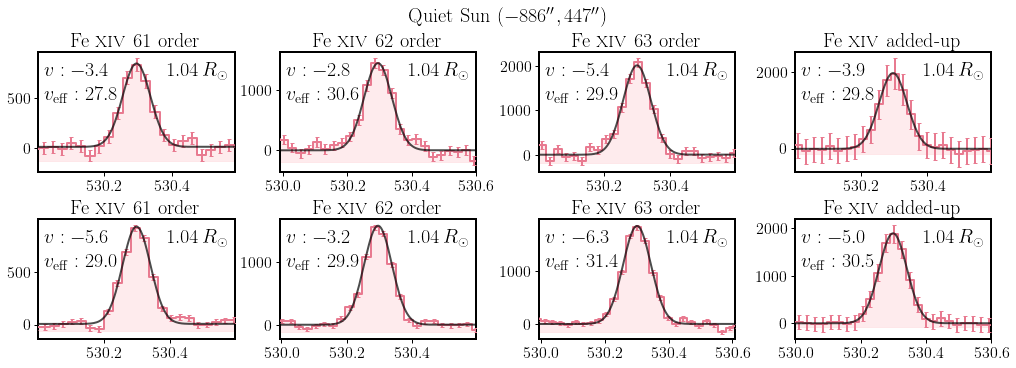

In [32]:
plot_3orders(-885,443,x_2d_grid_green_arcsec_rot_ext + slit_center_x_green,
                        y_2d_grid_green_arcsec_rot_ext + slit_center_y_green,
                        x_2d_grid_green_arcsec_bin_rot_ext + slit_center_x_green,
                        y_2d_grid_green_arcsec_bin_rot_ext + slit_center_y_green,
                         green_fit_filename_index, green_path,totality_green_df_ext,
                         FeXIV_xslices,flatfields,fit_matrices,fit_matrices_err,
                         fit_bin_matrices,fit_bin_matrices_err,title="Quiet Sun")

TotalitySequenceGreen_22716(3)_l1.fit 42


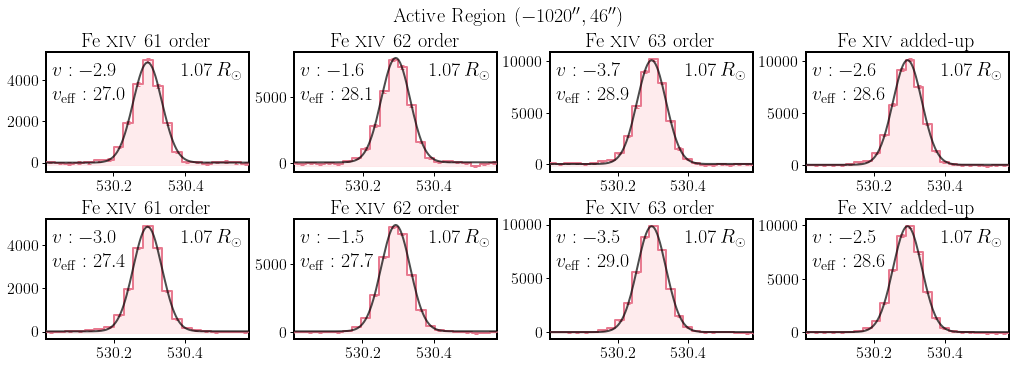

In [21]:
plot_3orders(-1020,42,x_2d_grid_green_arcsec_rot_ext + slit_center_x_green,
                        y_2d_grid_green_arcsec_rot_ext + slit_center_y_green,
                        x_2d_grid_green_arcsec_bin_rot_ext + slit_center_x_green,
                        y_2d_grid_green_arcsec_bin_rot_ext + slit_center_y_green,
                         green_fit_filename_index, green_path,totality_green_df_ext,
                         FeXIV_xslices,flatfields,fit_matrices,fit_matrices_err,
                         fit_bin_matrices,fit_bin_matrices_err,title="Active Region")

TotalitySequenceGreen_22720(3)_l1.fit 43


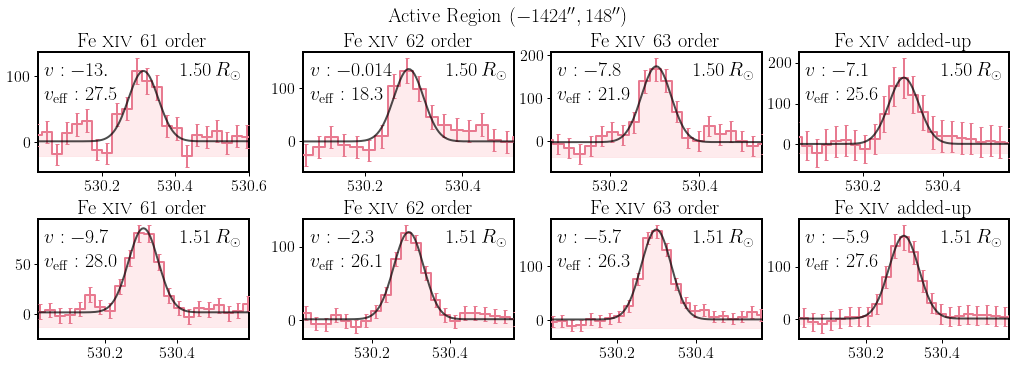

In [22]:
plot_3orders(-1424,154,x_2d_grid_green_arcsec_rot_ext + slit_center_x_green,
                        y_2d_grid_green_arcsec_rot_ext + slit_center_y_green,
                        x_2d_grid_green_arcsec_bin_rot_ext + slit_center_x_green,
                        y_2d_grid_green_arcsec_bin_rot_ext + slit_center_y_green,
                         green_fit_filename_index, green_path,totality_green_df_ext,
                         FeXIV_xslices,flatfields,fit_matrices,fit_matrices_err,
                         fit_bin_matrices,fit_bin_matrices_err,title="Active Region")

TotalitySequenceGreen_22713(3)_l1.fit 60


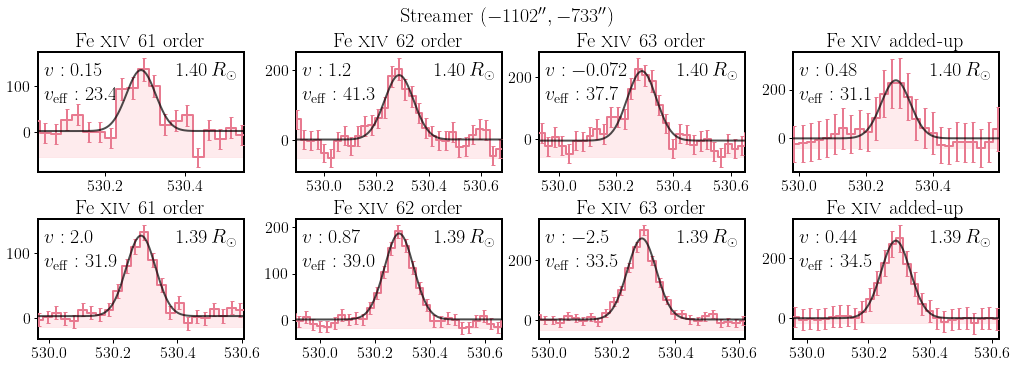

In [23]:
plot_3orders(-1103,-740,x_2d_grid_green_arcsec_rot_ext + slit_center_x_green,
                        y_2d_grid_green_arcsec_rot_ext + slit_center_y_green,
                        x_2d_grid_green_arcsec_bin_rot_ext + slit_center_x_green,
                        y_2d_grid_green_arcsec_bin_rot_ext + slit_center_y_green,
                         green_fit_filename_index, green_path,totality_green_df_ext,
                         FeXIV_xslices,flatfields,fit_matrices,fit_matrices_err,
                         fit_bin_matrices,fit_bin_matrices_err,title="Streamer")

TotalitySequenceGreen_22712(3)_l1.fit 58


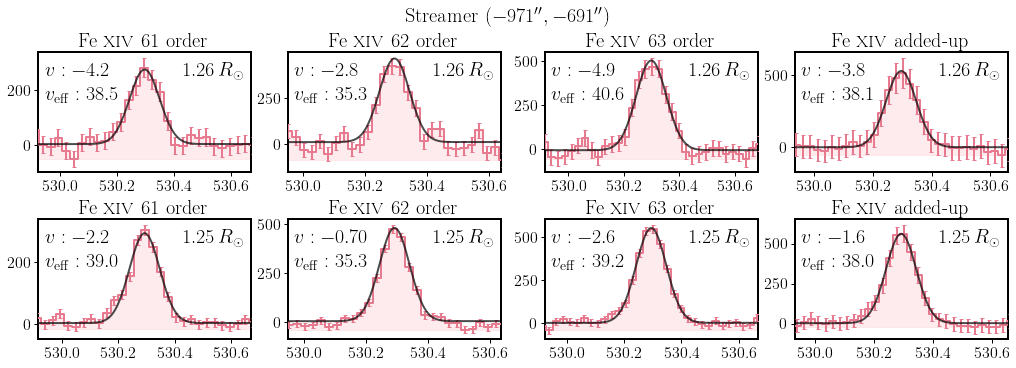

In [24]:
plot_3orders(-976,-694,x_2d_grid_green_arcsec_rot_ext + slit_center_x_green,
                        y_2d_grid_green_arcsec_rot_ext + slit_center_y_green,
                        x_2d_grid_green_arcsec_bin_rot_ext + slit_center_x_green,
                        y_2d_grid_green_arcsec_bin_rot_ext + slit_center_y_green,
                         green_fit_filename_index, green_path,totality_green_df_ext,
                         FeXIV_xslices,flatfields,fit_matrices,fit_matrices_err,
                         fit_bin_matrices,fit_bin_matrices_err,title="Streamer")

TotalitySequenceGreen_22717(3)_l1.fit 22


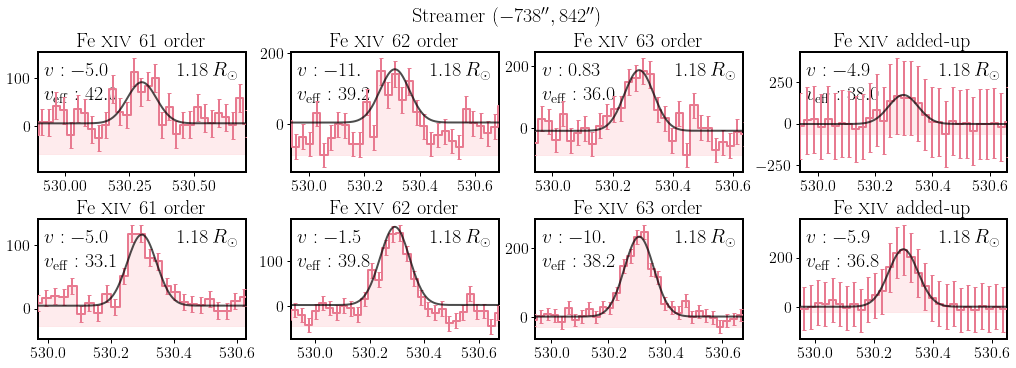

In [25]:
plot_3orders(-735,855,x_2d_grid_green_arcsec_rot_ext + slit_center_x_green,
                        y_2d_grid_green_arcsec_rot_ext + slit_center_y_green,
                        x_2d_grid_green_arcsec_bin_rot_ext + slit_center_x_green,
                        y_2d_grid_green_arcsec_bin_rot_ext + slit_center_y_green,
                         green_fit_filename_index, green_path,totality_green_df_ext,
                         FeXIV_xslices,flatfields,fit_matrices,fit_matrices_err,
                         fit_bin_matrices,fit_bin_matrices_err,title="Streamer")